In [ ]:
!pip install prophet


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/졸작/data/최종 사용 데이터/최종_빈도+소비_분석준비_0928.xlsx')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,일자,C1,C2,C3,C4,C5,C6,C7,M1,M2,M3,M4,M5,M6,M7,expenditure_tour
0,20221029,8,1,0,3,0,0,0,0,0,12,0,0,0,0,47794532000
1,20221030,1289,326,152,422,64,61,3,226,3,1560,295,193,7,33,37155395000
2,20221031,1380,516,273,189,215,120,6,486,12,1711,294,159,27,10,29237326000
3,20221101,1037,359,174,117,124,101,5,321,7,1106,241,178,55,9,29130528000
4,20221102,1077,319,189,57,109,59,19,301,0,1175,197,71,82,3,30257440000


In [ ]:
X = df[['C1',	'C2',	'C3',	'C4',	'C5',	'C6',	'C7',	'M1',	'M2',	'M3',	'M4',	'M5',	'M6',	'M7']]
y = df['expenditure_tour']

# Z-점수 표준화 - 독립변수만 진행(y는 안함)
scaler = StandardScaler()  # 변수명을 scaler로 수정
X_standardized = scaler.fit_transform(X)
X_standardized_df = pd.DataFrame(X_standardized, columns=X.columns)

In [ ]:
# 데이터 불러오기 (ds: 날짜, y: 종속변수)
df2 = pd.read_excel('/content/drive/MyDrive/졸작/data/최종 사용 데이터/최종_빈도+소비_분석준비_0928.xlsx')
df2 = df2[['일자', 'expenditure_tour']]
df2 = df2.rename(columns={'일자': 'ds', 'expenditure_tour': 'y'})
df2['ds'] = pd.to_datetime(df2['ds'].astype(str), format='%Y%m%d')
df2.head()


,ds,y
0,2022-10-29,47794532000
1,2022-10-30,37155395000
2,2022-10-31,29237326000
3,2022-11-01,29130528000
4,2022-11-02,30257440000


In [ ]:
# 훈련/검증 데이터셋 생성.
# 데이터 길이 확인
n = len(df2)

# 80%까지를 훈련 데이터로 사용
train_size = int(n * 0.7)
train_size

# 시간 순서대로 데이터 분할
df2_train = df2.iloc[:train_size]
df2_test = df2.iloc[train_size:]



In [ ]:
# 파라미터 탐색을 위한 그리드 서치
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# 최적 파라미터 탐색
best_params = None
best_rmse = float('inf')

for params in ParameterGrid(param_grid):
    model = Prophet(**params)
    model.fit(df2_train)

    future = model.make_future_dataframe(len(df2_test)) # 예측 구간 설정
    forecast = model.predict(future)

    # RMSE 계산
    actual = df2_test['y'].values
    # predicted = forecast['yhat'][:len(actual)].values
    predicted = forecast[-len(df2_test):]['yhat'].values
    # rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    rmse = np.sqrt(mean_squared_error(df2_test['y'], predicted))

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp6p4k7jk/r3w6jd8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp6p4k7jk/bju3m027.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31441', 'data', 'file=/tmp/tmpp6p4k7jk/r3w6jd8e.json', 'init=/tmp/tmpp6p4k7jk/bju3m027.json', 'output', 'file=/tmp/tmpp6p4k7jk/prophet_modelhjl949bq/prophet_model-20241022100853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:08:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:08:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}
Best RMSE: 6126277786.939543


In [ ]:
# 최적 파라미터로 모델 생성
optimal_model = Prophet(**best_params)
optimal_model.fit(df2_train)

# 예측 수행
future_optimal = optimal_model.make_future_dataframe(len(df2_test))
forecast_optimal = optimal_model.predict(future_optimal)

# RMSE 계산
from sklearn.metrics import mean_squared_error
import numpy as np

# 실제값과 예측값 비교 (yhat이 예측값)
predicted = forecast_optimal[-len(df2_test):]['yhat'].values
actual = df2_test['y'].values

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"RMSE: {rmse}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp6p4k7jk/9msvcerg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp6p4k7jk/4gen_402.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78619', 'data', 'file=/tmp/tmpp6p4k7jk/9msvcerg.json', 'init=/tmp/tmpp6p4k7jk/4gen_402.json', 'output', 'file=/tmp/tmpp6p4k7jk/prophet_modelfn8oshb3/prophet_model-20241022100903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:09:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:09:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 6126277786.939543


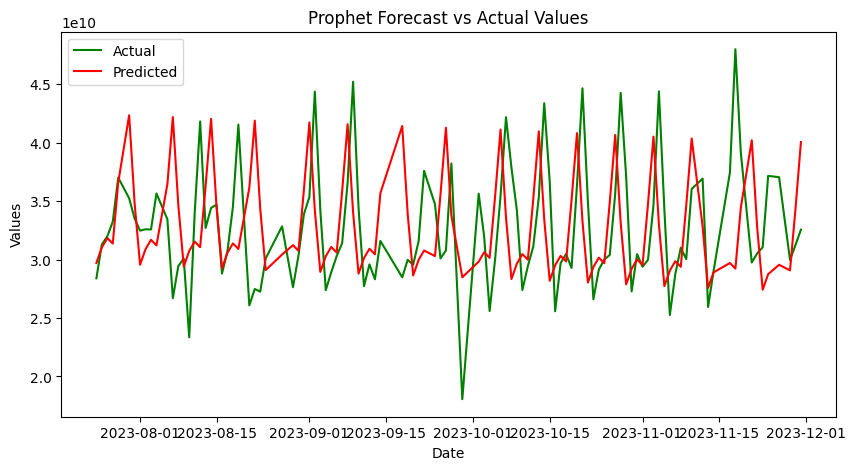

In [ ]:
import matplotlib.pyplot as plt


# 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 5))
# plt.plot(df2_train['ds'], df2_train['y'], label='Train', color='blue')
plt.plot(df2_test['ds'], df2_test['y'], label='Actual', color='green')
plt.plot(df2_test['ds'], predicted, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Prophet Forecast vs Actual Values')
plt.legend()
plt.show()

In [ ]:
# MAPE (Mean Absolute Percentage Error) 계산
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print('The MAPE of Prophet is:', mape, '%')


The MAPE of Prophet is: 14.450472327510585 %


In [ ]:
# df2_test['ds']

,ds
259,2023-07-24
260,2023-07-25
261,2023-07-26
262,2023-07-27
263,2023-07-28
...,...
365,2023-11-24
366,2023-11-26
367,2023-11-28
368,2023-11-29


In [ ]:
jjh = pd.DataFrame({'Date':df2_test['ds'], 'Predicted' : predicted, 'Actual' : actual})
jjh.to_excel('Prophet(외생X)_res.xlsx', index=False)